## Author: Nathaniel Ruhl
### This is a simple one-dimensional filter (only a single y50 state for a single energy band) for the 50% altitude measurement, written in terms of the predict and update phases of a Bayesian filter. 

In order to develop a Kalman Filter, we would need input from the navigational filter, and create equations to map from the position variences (cross-track, etc...) to y50 variences. Therefore, until we create those equations, the best we can do estimate how trustworthy a measurement is by its deviation from the model (the innovation). For this reason, I create a function for the "gain" of the y50 measurement based on the innovation.

In [3]:
# If x is the innovation of the measurement, we want to create an equation for the measurement gain, K_normalized(x), 
# which is of the form x*gaussian(x). In order for this function to reach a maximum value of 1,

# Code to help find the normalization factor for K_normalized()
import sympy as sp
sigma, pi, x, mu = sp.symbols("sigma, pi, x, mu")
K = x*sp.exp(-(x-mu)**2/(2*sigma**2))
sp.solve(sp.diff(K,x),x)[0]

mu/2 - sqrt(mu**2 + 4*sigma**2)/2

This is the x value at which the x*gaussian(x) reaches a maximum, which will be used to define the normalization factor in the code below. We can choose the x value that we want to fully trust the measurement.

In [5]:
import numpy as np

# This is the formula derived in Nate's 2023 Breck paper draft
def y50(alpha, SN):
    return 6496.949-0.0078*SN-6.430*alpha


# Simulate meausurements of y50 by creating random arrays of alpha and SN, add noise to y50 so it deviates from the model
sensor_var = 0.2   # varience of the measurement
std_amm = 1.37    # km
error_noise = 0.5   # km, extra error in a navigational scenario
measurement_noise = (std_amm+error_noise)*np.random.randn(100)

alpha_list = 2*np.pi*np.random.rand(100)
SN_list = 350*np.random.rand(100)

zs = y50(alpha_list, SN_list) + measurement_noise   # y50_measured

# Gain for a given measurement. The measurement, z, has an innovation x
def K_normalized(x):
    mean = 0.5*std_amm   # center of gain curve
    var = std_amm**2
    N = K(mean/2 + np.sqrt(mean**2 + 4*var)/2)  # normalization coeff
    return (1/N)*(x/np.sqrt(2*np.pi*var))*np.exp(-(x-mean)**2/(2*var))

# This is the normal x*gaussian(x) function, which is only called from K_normalized(x) to define the normalization factor
def K(x):
    mean = 0.5*std_amm
    var = std_amm**2
    return (x/np.sqrt(2*np.pi*var))*np.exp(-(x-mean)**2/(2*var))

y50_prediction = []
y50_estimate = []
innovation_list = []

for i in range(100):
    prior = y50(alpha_list[i], SN_list[i])
    innovation_list.append(abs(zs[i]-prior))
    kalman_gain = K_normalized(abs(zs[i]-prior))
    posterior = prior + kalman_gain*(zs[i]-prior)
    y50_prediction.append(prior)
    y50_estimate.append(posterior)
    
y50_prediction = np.array(y50_prediction)
y50_estimates = np.array(y50_estimate)
innovation_list = np.array(innovation_list)

Text(0, 0.5, 'y50')

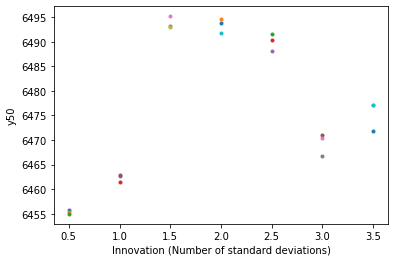

In [31]:
import matplotlib.pyplot as plt
# We want to plot certain data points with different innovations
sort_index = np.argsort(innovation_list).astype(int)
innovations_sorted = innovation_list[sort_index]

for innov in [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5]:
    indx = np.where(innovations_sorted>=innov*std_amm)[0][0]
    plt.plot(innov, y50_prediction[sort_index][indx], '.', label="Prediction")
    plt.plot(innov, y50_estimates[sort_index][indx], '.', label="Estimate")
    plt.plot(innov, zs[sort_index][indx], '.', label="Measurement")

plt.xlabel("Innovation (Number of standard deviations)")
plt.ylabel("y50")
# plt.plot(innovation_list, y50_prediction,'.', label="Prediction")
# plt.plot(innovation_list, y50_estimate, ".", label="Estimate")
# plt.plot(innovation_list, zs, '.', label="Measurement")
# plt.legend()

This plot is not great, but it shows how the estimate is right in the middle of the predicted y50 and the measured y50 at 0.5*std_amm, almost fully trusting the measurement at 1.0*std_amm, and almost fully trusting the model at 3.5*std_amm.
This is better seen in the plot of the gain below

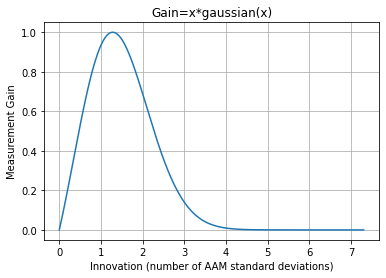

In [32]:
x=np.linspace(0,10,1000)
plt.plot(x/std_amm,K_normalized(x))
plt.title('Gain=x*gaussian(x)')
plt.xlabel("Innovation (number of AAM standard deviations)")
plt.ylabel("Measurement Gain")
plt.grid()

Text(0.5, 0, 'abs(measurement noise)')

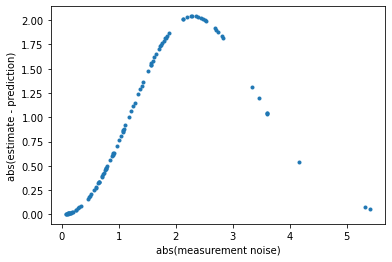

In [33]:
plt.plot(abs(measurement_noise), abs(y50_estimate-y50_prediction), '.')
plt.ylabel("abs(estimate - prediction)")
plt.xlabel("abs(measurement noise)")